### Gaussian Shot Noise for Curves (Pieter Derksen)

The following notebook demonstrates the effect of Gaussian shot noise (described below) on the classification of curves into different clusters. The specific example used in the notebook is the set of cancer cells that are provided in geomstats, but is applicable to all sets of curves.

Many of the datasets that scientists work with have significant sources of labeling error, either due to the humans that label those datasets or the ability of algorithms that we use to label large amounts of data from small amounts of labeled data. One specific type of data frequently subject to these errors is labeled curves (e.g. outlines of cells or other bodies, measurements of the position of a moving object through its trajectory, etc.) which are, in the simplest form, a series of many points. The three categories of error that we might encounter are small amounts of noise for many points, large amounts of noise for a select few points, and large amounts of noise for many points. We would like to see how each of these categories propagates through clustering analysis in order to give us some sense of the reliability of clustering on datasets.

We are going to say all of these categories can be described as Gaussian shot noise. The basic idea is each point will have some probability of being noisy, and for each point that is noisy, the noise will be Gaussian distributed with some width. The different categories of noise can be accessed by tuning the probability and width (i.e. high probability and low noise, low probability and high noise, and high probability and high noise) for each iteration of clustering. We will compare the ability of two types of clustering (Kmeans and Riemannian MDM) for many different combinations of probability and noise to see how reliable clustering can be in each of these circumstances.

### Standard Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Project Imports

In [2]:
import geomstats.backend as gs
import geomstats.datasets.utils as data_utils

from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import ClosedDiscreteCurves, DiscreteCurves, R2, SRVShapeBundle
from geomstats.geometry.pre_shape import PreShapeSpace
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans

from scipy import stats
from scipy.optimize import linear_sum_assignment as linear_assignment

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

INFO: Using numpy backend


### Project Functions
The purpose of each function is documented below and how these functions are used will be described throughout the notebook, both as markdown text and comments in the code itself. The types of functions are curve processing (three functions), adding noise to curves (one function), dictionary of curves processing (two functions), plotting distances (two functions), Kmeans (two functions), plotting Kmeans / Riemannian MDM results (two functions), and Kmeans / Riemannian MDM accuracy computation (two functions).

In [3]:
def curve_length(curve) :
    """Computes the length of a discrete curve.
    
    Parameters
    ----------
    curve : array-like
        Discrete curve for which length will be computed.
    
    Returns
    -------
    length : float
        Length of discrete curve.
    """
    length = sum([
        gs.linalg.norm(curve[l + 1] - curve[l]) 
        for l in range(0, len(curve) - 1)
               ])
    return length

def interpolate(curve, nb_points) :
    """Interpolate a discrete curve with nb_points from a discrete curve.
    
    Parameters
    ----------
    curve : array-like
        Discrete curve that is going to be interpolated.
    nb_points : int
        Number of points to interpolate on the curve.
    
    Returns
    -------
    interpolation : array-like
        Interpolated curve with nb_points.
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points) :
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation

def preprocess(curve, tol = 1e-8) :
    """Preprocess curve to ensure that there are no consecutive duplicate points.
    
    Parameters
    ----------
    curve : array-like
        Original curve that is going to be preprocessed.
    tol : float
        Distance between points for which to consider them duplicate.
    
    Returns
    -------
    curve : array-like
        Preprocessed curve with no duplicate points.
    """
    dist = curve[1:] - curve[:-1]
    dist_norm = gs.sqrt(gs.sum(dist**2, axis = 1))
    if gs.any(dist_norm < tol) :
        for i in range(len(curve) - 1):
            if gs.sqrt(gs.sum(np.square(curve[i + 1] - curve[i]), axis = 0)) < tol :
                curve[i + 1] = (curve[i] + curve[i + 2]) / 2
    return curve

def curve_shot_noise(curve, probability, sigma) :
    """Add shot noise to a discrete curve.
    
    Parameters
    ----------
    curve : array-like
        Discrete curve that is going to have noise added.
    probability : float
        Probability of a given point being noisy.
    sigma : float
        Width of the Gaussian to use for noise.
    
    Returns
    -------
    noisy_curve : array-like
        Curve with added Gaussian noise normal to the discrete curve.
    """
    normals = gs.empty(curve.shape)
    for idx in range(curve.shape[0]) :
        t_1 = curve[(idx + 1) % curve.shape[0]] - curve[idx]
        t_2 = curve[idx - 1] - curve[idx]
        normal = t_1 * gs.linalg.norm(t_2) + gs.linalg.norm(t_1) * t_2
        if gs.linalg.norm(normal) > 0 :
            normals[idx] = normal / gs.linalg.norm(normal)
        else :
            normals[idx] = normal
    noisy_curve = curve + normals * gs.random.normal(0.0, sigma, size = (normals.shape[0], 1)) * gs.random.choice([0, 1], size = (normals.shape[0], 1), p = [1 - probability, probability])
    return noisy_curve

def apply_func_to_ds(input_ds, treatments, lines, func) :
    """Apply the input function func to the input dictionary input_ds.

    Parameters
    ----------
    input_ds : dict
        Input dictionary, with keys [treatment][line].
    func : callable
        Function to be applied to the values of the dictionary.

    Returns
    -------
    output_ds : dict
        Output dictionary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in treatments :
        output_ds[treatment] = {}
        for line in lines :
            output_list = []
            for one_cell in input_ds[treatment][line] :
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

def unpack_dictionary(input_ds) :
    """Unpacks a dictionary into a flat array.

    Parameters
    ----------
    input_ds : dict
        Input dictionary, with keys treatment-line.

    Returns
    -------
    curve_array : array
        Output array, with all the values of the dictionary.
    """
    curve_list = []
    for key, val in input_ds.items() :
        for k, v in val.items() :
            curve_list.append(v)
    curve_array = np.concatenate(curve_list)
    return curve_array

def full_hist_dists_to_means_split(dists, treatments_labels, lines_labels) :
    """Creates multiple plots of distances to mean for each treatment-line combination.

    Parameters
    ----------
    dists : array
        Input dictionary, with keys treatment-line.
    treatments_labels : array
        Input array, with all treatment labels.
    lines_labels : array
        Input array, with all lines labels.
    """
    min_dists = gs.array(min(unpack_dictionary(dists)))
    max_dists = gs.array(max(unpack_dictionary(dists)))
    xx = gs.linspace(min_dists, max_dists, 100)
    fig, axs = plt.subplots(len(np.unique(treatments_labels)), len(np.unique(lines_labels)), figsize = (18, 8))
    for i_lab_a, label_a in enumerate(treatments_labels) :
        for i_lab_b, label_b in enumerate(np.unique(lines_labels)) :
            dist = dists[label_a][label_b]
            axs[i_lab_a, i_lab_b].hist(
                dist, bins = 20, alpha = 0.4, density = True, label = label_a + "-" + label_b, color = f"C{i_lab_a+2*i_lab_b}"
            )
            kde = stats.gaussian_kde(dist)
            axs[i_lab_a, i_lab_b].plot(xx, kde(xx), color = f"C{i_lab_a+2*i_lab_b}")
            axs[i_lab_a, i_lab_b].legend()
            axs[i_lab_a, i_lab_b].set_title(f"Distances to SRV mean ")
        plt.tight_layout()

def full_hist_dists_to_means_gather(dists, treatments_labels, lines_labels) :
    """Creates single plot of distances to mean of all treatment-line combinations.

    Parameters
    ----------
    dists : array
        Input dictionary, with keys treatment-line.
    treatments_labels : array
        Input array, with all treatment labels.
    lines_labels : array
        Input array, with all lines labels.
    
    """
    min_dists = gs.array(min(unpack_dictionary(dists)))
    max_dists = gs.array(max(unpack_dictionary(dists)))
    xx = gs.linspace(min_dists, max_dists, 100)
    fig, axs = plt.subplots(1, 1, figsize = (18, 8))
    for i_lab_a, label_a in enumerate(treatments_labels):
        for i_lab_b, label_b in enumerate(np.unique(lines_labels)):
            dist = dists[label_a][label_b]
            axs.hist(
                dist, bins = 20, alpha = 0.4, density = True, label = label_a + "-" + label_b, color = f"C{i_lab_a+2*i_lab_b}"
            )
            kde = stats.gaussian_kde(dist)
            axs.plot(xx, kde(xx), color = f"C{i_lab_a+2*i_lab_b}")
            axs.legend()
            axs.set_title(f"Distances to SRV mean")
        plt.tight_layout()


def _make_cost_m(cm) :
    """Creates confusion matrix for performing Kmeans clustering.

    Parameters
    ----------
    cm : array
        The initial confusion matrix.
    """
    s = np.max(cm)
    return - cm + s

def reorder_confusion_matrix(cmat) :
    """Reorders confusion matrix that is output from Kmeans clustering.

    Parameters
    ----------
    cmat : array
        Confusion matrix to be reordered.
    
    """
    indexes = linear_assignment(_make_cost_m(cmat))
    js = sorted(indexes, key = lambda x: x[0])[1]
    cm2 = cmat[:, js]
    return cm2

def confusion_kmean_double(labels_01, labels_02, name_01, name_02, dict_01, dict_02, dists_summary) :
    """ Perform Kmeans clustering and plot classifications.

    Parameters
    ----------
    labels_01 : array
        Set of labels for treatments.
    labels_02 : array
        Set of labels for cell lines.
    name_01 : string
        'treatments' for the set of cancer cells.
    name_02 : string
        'lines' for the set of cancer cells.
    dict_01 : dict
        Input dictionary, with keys treatment.
    dict_02 : dict
        Input dictionary, with keys line.
    dists_summary : dict
        Input diciontary, with distance of each curve from Frechet mean.
    """
    #
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    dists_arr = gs.expand_dims(gs.array(dists_summary['data']), axis = 1)

    # create treatments plot
    kmeans = KMeans(n_clusters=len(dict_01), random_state=0).fit(dists_arr)
    true_labels = [dict_01[lab] for lab in labels_01]
    cm = confusion_matrix(true_labels, kmeans.labels_)
    cm = reorder_confusion_matrix(cm)
    axs[0].imshow(cm, interpolation = "none", cmap = "Blues")
    for (ii, jj), z in np.ndenumerate(cm):
        axs[0].text(jj, ii, z, ha="center", va="center")
    axs[0].axes.xaxis.set_ticks([val for val in dict_01.values()], [lab for lab in dict_01])
    axs[0].axes.yaxis.set_ticks([val for val in dict_01.values()], [lab for lab in dict_01])
    axs[0].set_xlabel("Kmeans labels")
    axs[0].set_ylabel("True labels")
    acc = 100 * (np.trace(cm) / np.sum(cm))
    axs[0].set_title(
        f"Clustering {name_01} using \n  distances to SRV mean \n Accuracy: {acc:.2f}%")
    
    # create lines plot
    kmeans = KMeans(n_clusters=len(dict_02), random_state=0).fit(dists_arr)
    true_labels = [dict_02[lab] for lab in labels_02]
    cm = confusion_matrix(true_labels, kmeans.labels_)
    cm = reorder_confusion_matrix(cm)
    axs[1].imshow(cm, interpolation="none", cmap="Blues")
    for (ii, jj), z in np.ndenumerate(cm):
        axs[1].text(jj, ii, z, ha="center", va="center")
    axs[1].axes.xaxis.set_ticks([val for val in dict_02.values()], [lab for lab in dict_02])
    axs[1].axes.yaxis.set_ticks([val for val in dict_02.values()], [lab for lab in dict_02])
    axs[1].set_xlabel("Kmeans labels")
    axs[1].set_ylabel("True labels")
    acc = 100 * (np.trace(cm) / np.sum(cm))
    axs[1].set_title(
        f"Clustering {name_02} using \n  distances to SRV mean \n Accuracy: {acc:.2f}%")

def confusion_mdm_double(labels_01, labels_02, name_01, name_02, dict_01, dict_02, dists_summary) :
    """ Perform Riemannian MDM clustering and plot classifications.

    Parameters
    ----------
    labels_01 : array
        Set of labels for treatments.
    labels_02 : array
        Set of labels for cell lines.
    name_01 : string
        'treatments' for the set of cancer cells.
    name_02 : string
        'lines' for the set of cancer cells.
    dict_01 : dict
        Input dictionary, with keys treatment.
    dict_02 : dict
        Input dictionary, with keys line.
    dists_summary : dict
        Input diciontary, with distance of each curve from Frechet mean.
    """
    fig, axs = plt.subplots(1, 2, figsize = (18, 8))
    dists_arr = gs.expand_dims(gs.array(dists_summary['data']), axis = 1)

    # create treatments plot
    true_labels_ints = [dict_01[lab] for lab in labels_01]
    means_of_each_label = []
    for i_lab, lab in enumerate(np.unique(labels_01)):
        means_of_each_label.append(np.mean(  # mean of scalars in both cases
            dists_summary['data'][dists_summary[name_01] == lab]))
    pred_labels_ints = [] 
    for dist_cell in dists_arr:
        distdists = np.array([np.abs(dist_cell - m) for m in means_of_each_label])
        pred_labels_ints.append(np.argmin(distdists))
    cm = confusion_matrix(true_labels_ints, pred_labels_ints)
    cm = reorder_confusion_matrix(cm)
    axs[0].imshow(cm, interpolation = "none", cmap = "Blues")
    for (ii, jj), z in np.ndenumerate(cm) :
        axs[0].text(jj, ii, z, ha="center", va="center")
    axs[0].axes.xaxis.set_ticks([val for val in dict_01.values()], [lab for lab in dict_01])
    axs[0].axes.yaxis.set_ticks([val for val in dict_01.values()], [lab for lab in dict_01])
    axs[0].set_xlabel("MDM labels")
    axs[0].set_ylabel("True labels")
    acc = 100 * (np.trace(cm) / np.sum(cm))
    axs[0].set_title(
        f"Classifying {name_01} using \n  distances to SRV mean \n Accuracy: {acc:.2f}%")
    
    # create lines plot
    true_labels_ints = [dict_02[lab] for lab in labels_02]
    means_of_each_label = []
    for i_lab, lab in enumerate(np.unique(labels_02)):
        means_of_each_label.append(np.mean(  # mean of scalars in both cases
            dists_summary['data'][dists_summary[name_02] == lab]))
    pred_labels_ints = [] 
    for dist_cell in dists_arr:
        distdists = np.array([np.abs(dist_cell - m) for m in means_of_each_label])
        pred_labels_ints.append(np.argmin(distdists))
    cm = confusion_matrix(true_labels_ints, pred_labels_ints)
    cm = reorder_confusion_matrix(cm)
    axs[1].imshow(cm, interpolation = "none", cmap = "Blues")
    for (ii, jj), z in np.ndenumerate(cm) :
        axs[1].text(jj, ii, z, ha="center", va="center")
    axs[1].axes.xaxis.set_ticks([val for val in dict_02.values()], [lab for lab in dict_02])
    axs[1].axes.yaxis.set_ticks([val for val in dict_02.values()], [lab for lab in dict_02])
    axs[1].set_xlabel("MDM labels")
    axs[1].set_ylabel("True labels")
    acc = 100 * (np.trace(cm) / np.sum(cm))
    axs[1].set_title(
        f"Classifying {name_01} using \n  distances to SRV mean \n Accuracy: {acc:.2f}%")

def kmean_accuracy(labels_01, labels_02, name_01, name_02, dict_01, dict_02, dists_summary) :
    """ Perform Kmeans clustering and compute accuracy of classification.

    Parameters
    ----------
    labels_01 : array
        Set of labels for treatments.
    labels_02 : array
        Set of labels for cell lines.
    name_01 : string
        'treatments' for the set of cancer cells.
    name_02 : string
        'lines' for the set of cancer cells.
    dict_01 : dict
        Input dictionary, with keys treatment.
    dict_02 : dict
        Input dictionary, with keys line.
    dists_summary : dict
        Input diciontary, with distance of each curve from Frechet mean.

    Returns
    -------
    acc : array
        Accuracy of Kmeans clustering for treatments and lines.
    """
    #
    dists_arr = gs.expand_dims(gs.array(dists_summary['data']), axis = 1)
    acc = np.empty(2)

    # create treatments plot
    kmeans = KMeans(n_clusters=len(dict_01), random_state=0).fit(dists_arr)
    true_labels = [dict_01[lab] for lab in labels_01]
    cm = confusion_matrix(true_labels, kmeans.labels_)
    cm = reorder_confusion_matrix(cm)
    acc[0] = 100 * (np.trace(cm) / np.sum(cm))
    
    # create lines plot
    kmeans = KMeans(n_clusters=len(dict_02), random_state=0).fit(dists_arr)
    true_labels = [dict_02[lab] for lab in labels_02]
    cm = confusion_matrix(true_labels, kmeans.labels_)
    cm = reorder_confusion_matrix(cm)
    acc[1] = 100 * (np.trace(cm) / np.sum(cm))
    return acc

def mdm_accuracy(labels_01, labels_02, name_01, name_02, dict_01, dict_02, dists_summary) :
    """ Perform Riemannian MDM clustering and compute accuracy of classification.

    Parameters
    ----------
    labels_01 : array
        Set of labels for treatments.
    labels_02 : array
        Set of labels for cell lines.
    name_01 : string
        'treatments' for the set of cancer cells.
    name_02 : string
        'lines' for the set of cancer cells.
    dict_01 : dict
        Input dictionary, with keys treatment.
    dict_02 : dict
        Input dictionary, with keys line.
    dists_summary : dict
        Input diciontary, with distance of each curve from Frechet mean.

    Returns
    -------
    acc : array
        Accuracy of Riemannian MDM clustering for treatments and lines.
    """
    dists_arr = gs.expand_dims(gs.array(dists_summary['data']), axis = 1)
    acc = np.empty(2)

    # create treatments plot
    true_labels_ints = [dict_01[lab] for lab in labels_01]
    means_of_each_label = []
    for i_lab, lab in enumerate(np.unique(labels_01)):
        means_of_each_label.append(np.mean(  # mean of scalars in both cases
            dists_summary['data'][dists_summary[name_01] == lab]))
    pred_labels_ints = [] 
    for dist_cell in dists_arr:
        distdists = np.array([np.abs(dist_cell - m) for m in means_of_each_label])
        pred_labels_ints.append(np.argmin(distdists))
    cm = confusion_matrix(true_labels_ints, pred_labels_ints)
    cm = reorder_confusion_matrix(cm)
    acc[0] = 100 * (np.trace(cm) / np.sum(cm))
    
    # create lines plot
    true_labels_ints = [dict_02[lab] for lab in labels_02]
    means_of_each_label = []
    for i_lab, lab in enumerate(np.unique(labels_02)):
        means_of_each_label.append(np.mean(  # mean of scalars in both cases
            dists_summary['data'][dists_summary[name_02] == lab]))
    pred_labels_ints = [] 
    for dist_cell in dists_arr:
        distdists = np.array([np.abs(dist_cell - m) for m in means_of_each_label])
        pred_labels_ints.append(np.argmin(distdists))
    cm = confusion_matrix(true_labels_ints, pred_labels_ints)
    cm = reorder_confusion_matrix(cm)
    acc[1] = 100 * (np.trace(cm) / np.sum(cm))
    return acc

### Load Project Data
We load in the dataset for cancer cells. We create lists of the treatments and cell lines, and dictionary with numerical identifiers for each treatment and cell line. We choose the number of sampling points that we want to use for each curve.

In [4]:
# load project data of cancer cells
cells, lines, treatments = data_utils.load_cells()

# create treatment and line lists and dictionaries
treatments_labels = np.unique(treatments)
lines_labels = np.unique(lines)
treatments_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(treatments))}
lines_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(lines))}

# number of sampling points and metric
k_sampling_points = 100
r2 = Euclidean(dim = 2)

# create necessary geomstats objects
curves_r2 = DiscreteCurves(ambient_manifold = r2)
preshape = PreShapeSpace(m_ambient = 2, k_landmarks = k_sampling_points)
shape_bundle = SRVShapeBundle(ambient_manifold = r2, k_sampling_points = k_sampling_points)
srv_metric = curves_r2.srv_metric

### Create dictionary of cells
We create a dictionary of all the cells in the dataset with the treatments and lines as keys.

In [5]:
ds = {}
n_cells_arr = np.zeros((3, 2))
for i, treatment in enumerate(treatments_labels) :
    ds[treatment] = {}
    for j, line in enumerate(lines_labels) :
        to_keep = np.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]

### Original dataset without any synthetic noise
We are going to do the analysis on the original dataset without any synthetic noise to provide a point of comparison. ds_interp applies the interpolation and preprocessing functions to the original cell dictionary so that each one has the same number of points and none of the points overlap. ds_translate removes translation from the dataset. ds_preshape removes the curve length from the dataset. We compute the Frechet mean of the entire dataset and the distance of each curve from the mean. We do Kmeans clustering and Riemannian MDM on the distances to see how accurate the algorithms will be on the original dataset.

c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

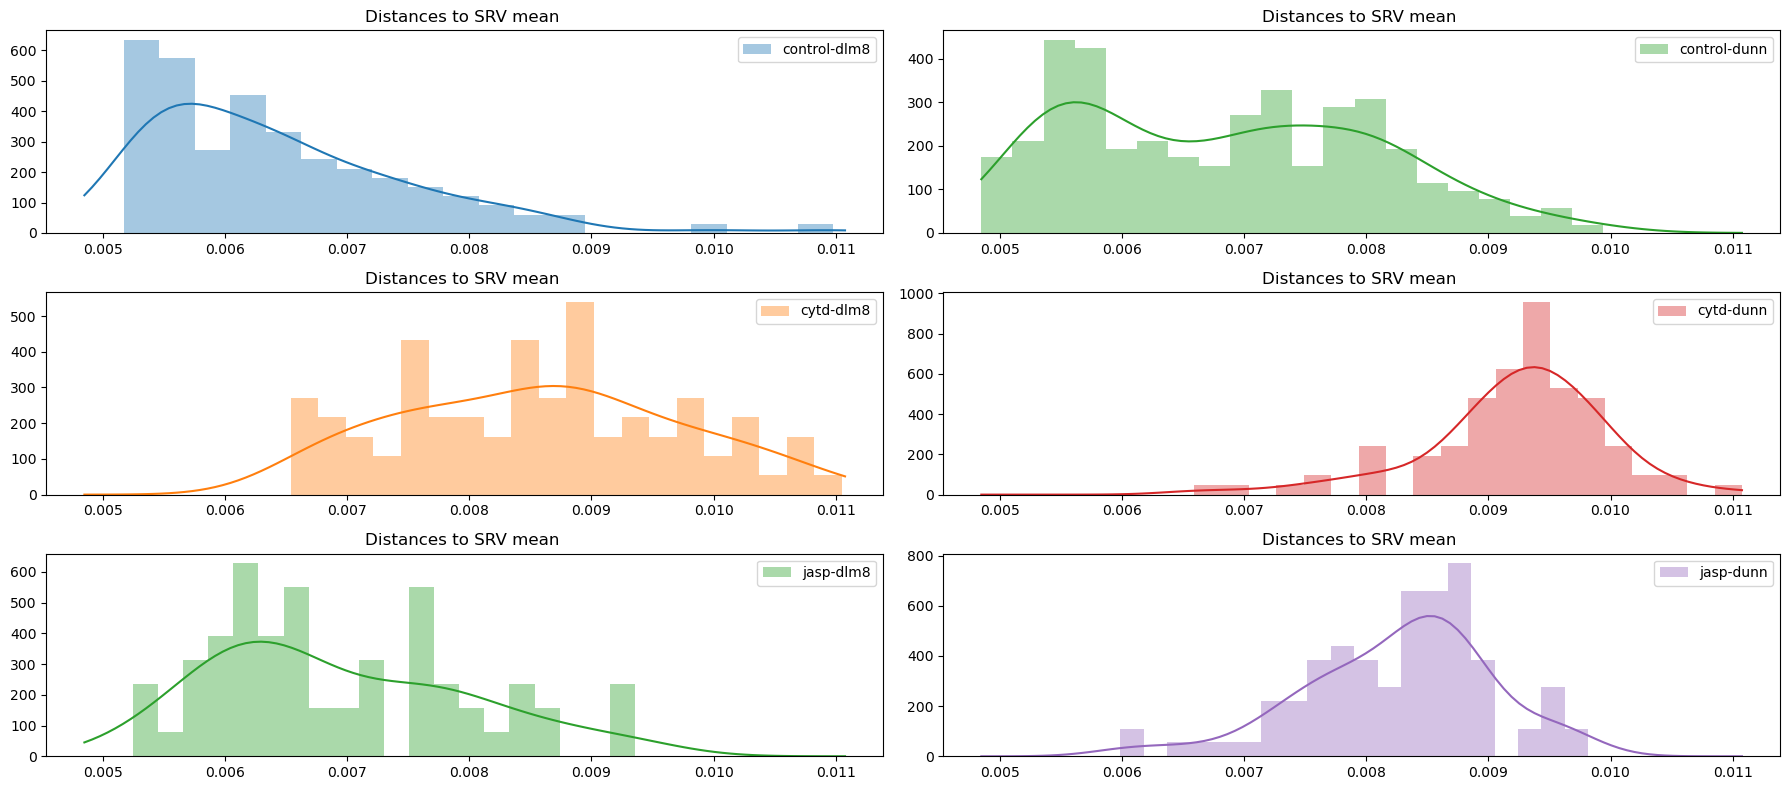

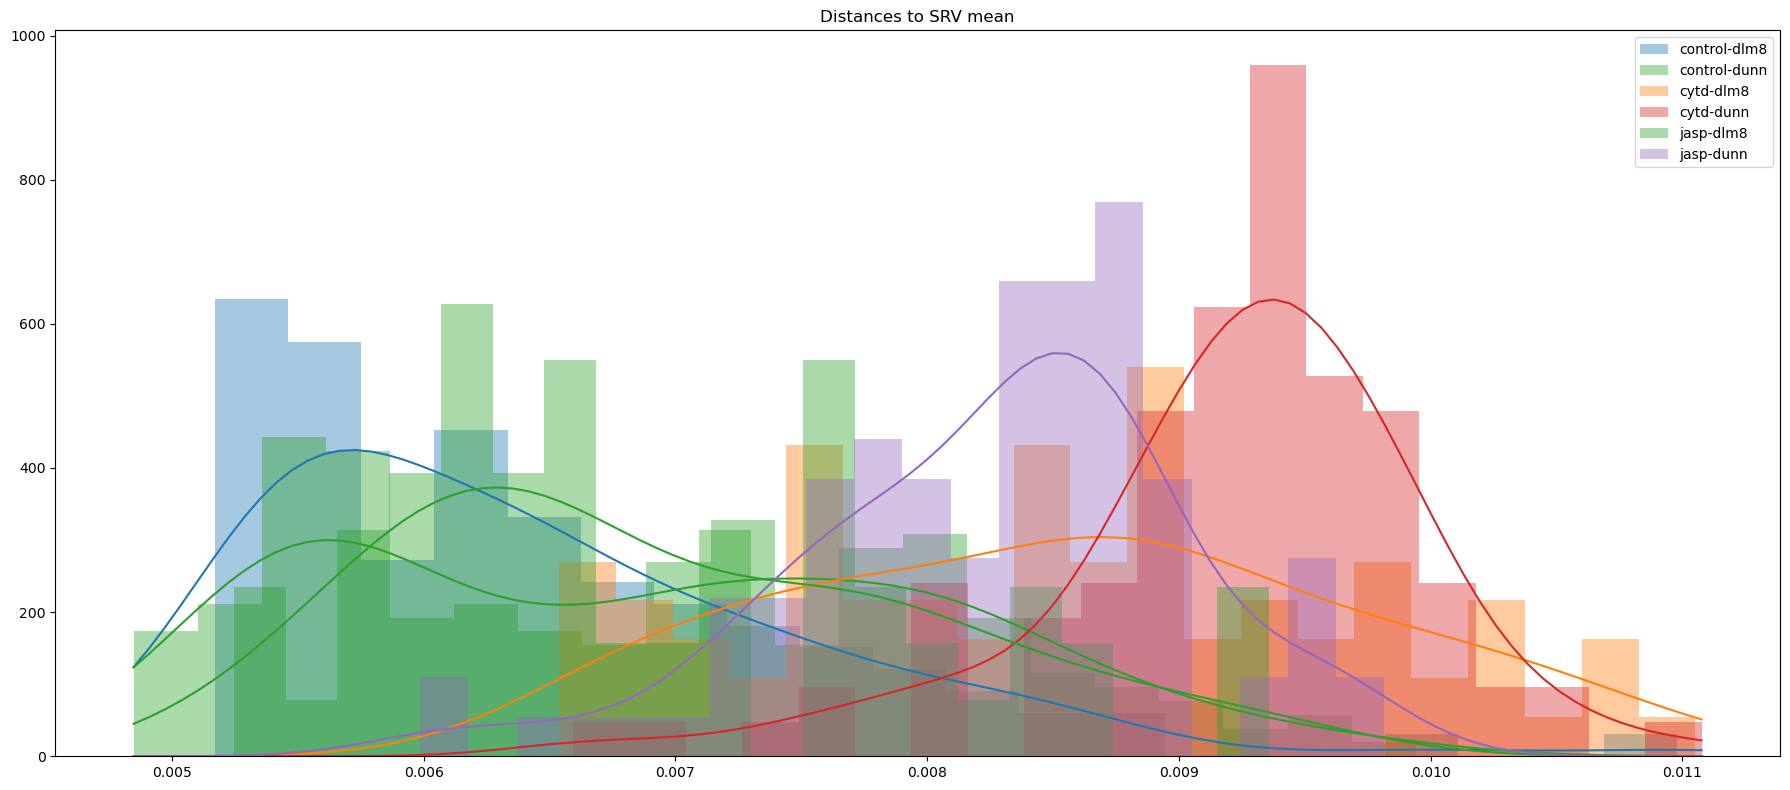

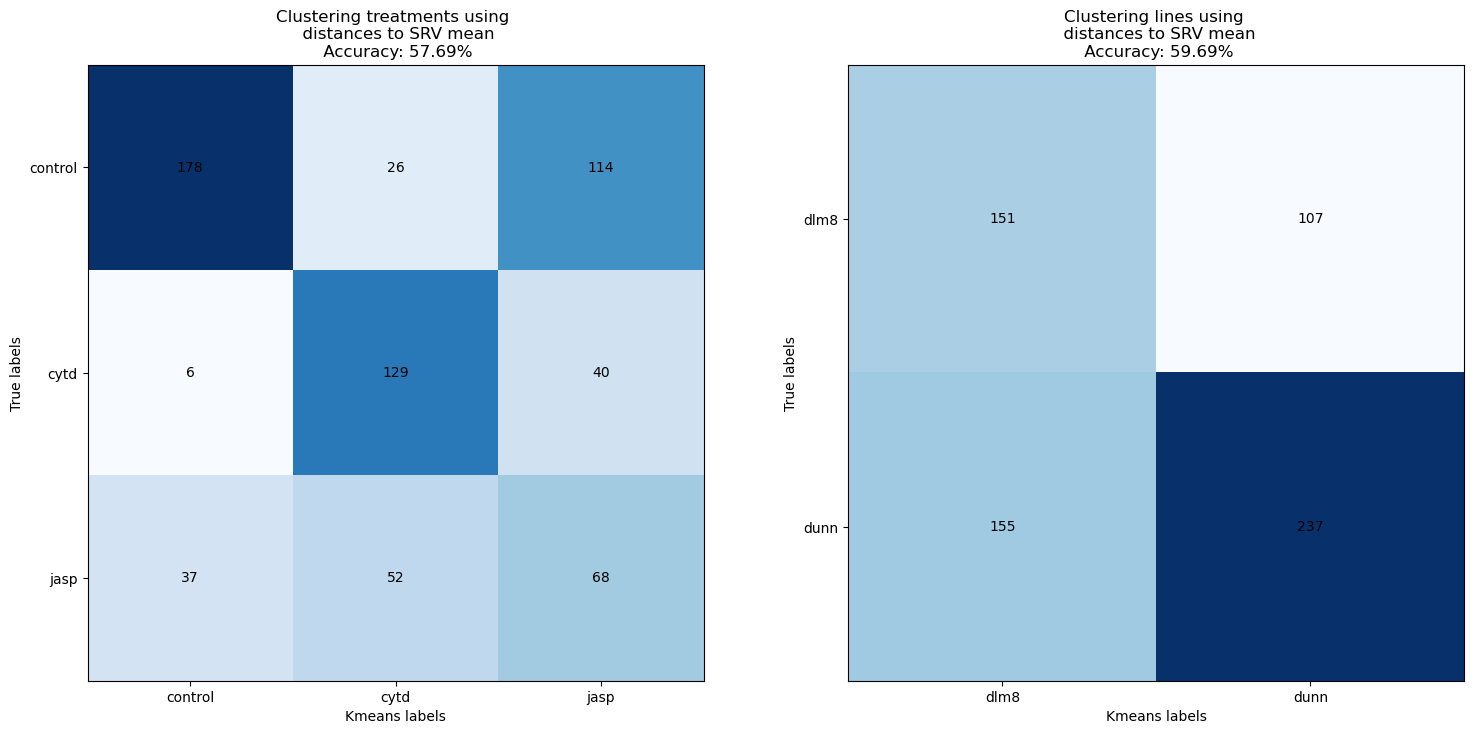

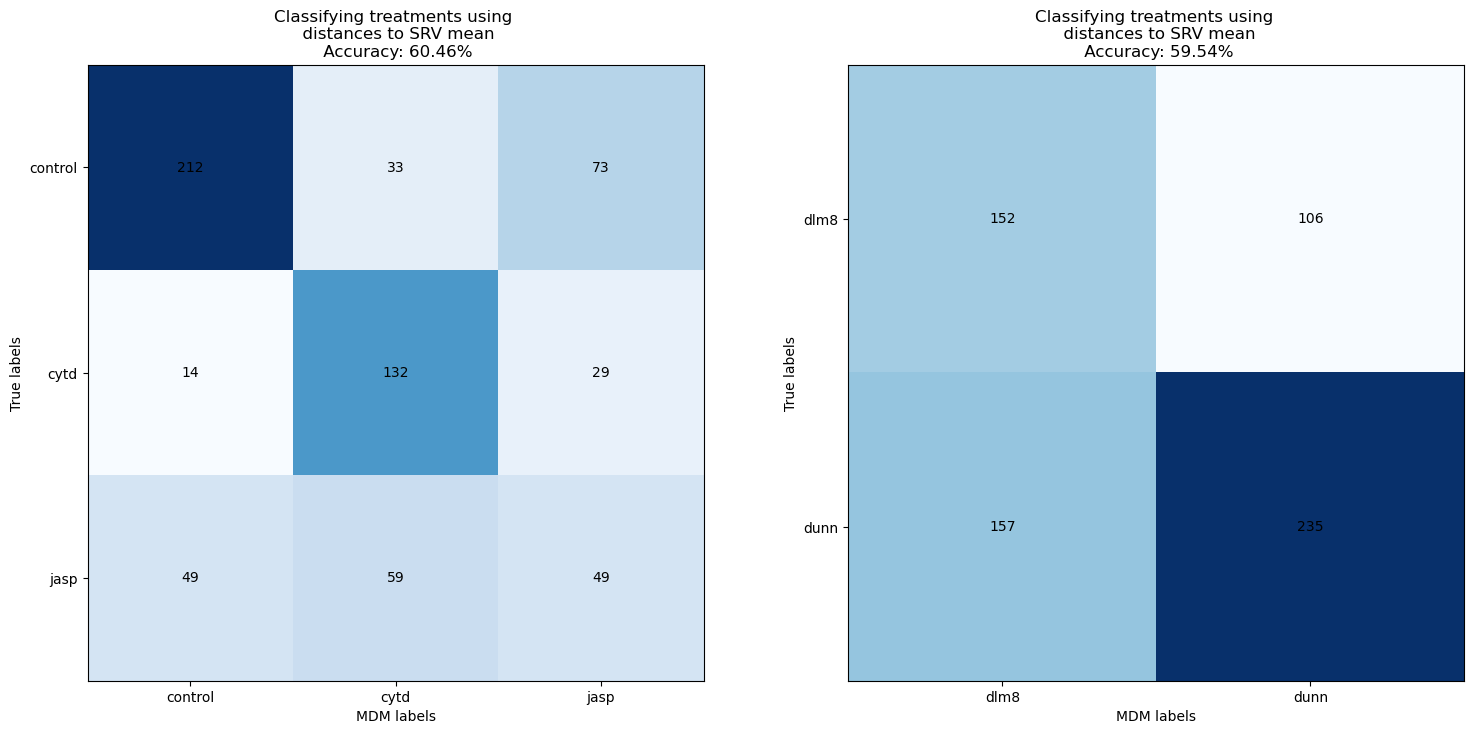

In [6]:
ds_interp = apply_func_to_ds(
    input_ds = ds,
    treatments = treatments_labels,
    lines = lines_labels,
    func = lambda x : preprocess(interpolate(x, k_sampling_points))
)

ds_translate = apply_func_to_ds(
    input_ds = ds_interp,
    treatments = treatments_labels,
    lines = lines_labels,
    func = lambda x : preshape.projection(x)
)

ds_preshape = apply_func_to_ds(
    input_ds = ds_translate,
    treatments = treatments_labels,
    lines = lines_labels,
    func = lambda x : x / curve_length(x)
)

mean = FrechetMean(
            metric = srv_metric, 
            method = "default").fit(unpack_dictionary(ds_preshape)).estimate_

dists = {}
for treatment in treatments_labels :
    dists[treatment] = {}
    for line in lines_labels :
        dists[treatment][line] = [srv_metric.dist(mean, curve) / k_sampling_points for curve in ds_preshape[treatment][line]]

dists_summary = pd.DataFrame(
    data = {
        'treatments': treatments,
        'lines': lines,
        'data': unpack_dictionary(dists)
    }
)

full_hist_dists_to_means_split(dists, treatments_labels, lines_labels)
full_hist_dists_to_means_gather(dists, treatments_labels, lines_labels)
confusion_kmean_double(treatments, lines, 'treatments', 'lines', treatments_dict, lines_dict, dists_summary)
confusion_mdm_double(treatments, lines, 'treatments', 'lines', treatments_dict, lines_dict, dists_summary)

### Noisy dataset
We are going to do the analysis on the noisy dataset with p = probability of any point on the curve being noisy and sigma = the width of the Gaussian perpendicular to the curve. We choose the noise to be perpendicular to the curve because any noise parallel to the curve would be accounted for with reparameterization. ds_noisy applies to the noise procedure to the output of ds_interp from before. ds_translate removes translation from the dataset. ds_preshape removes the curve length from the dataset. We compute the Frechet mean of the entire dataset and the distance of each curve from the mean. We do Kmeans clustering and Riemannian MDM on the distances to see how accurate the algorithms will be on the noisy dataset compared to the original dataset.

c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\piete\.conda\envs\ece594n\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

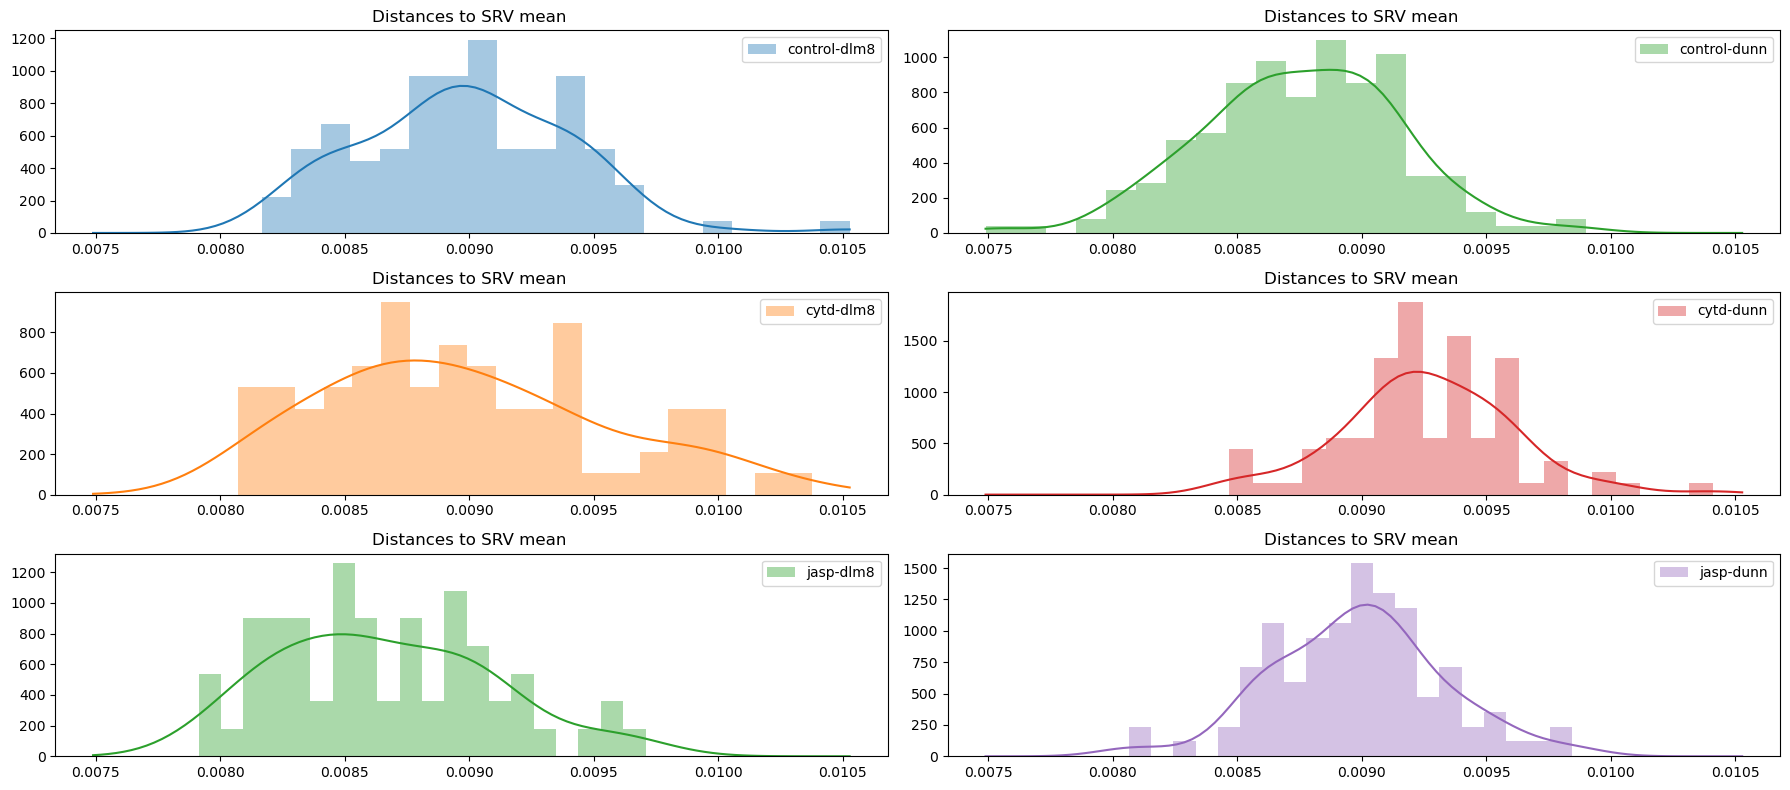

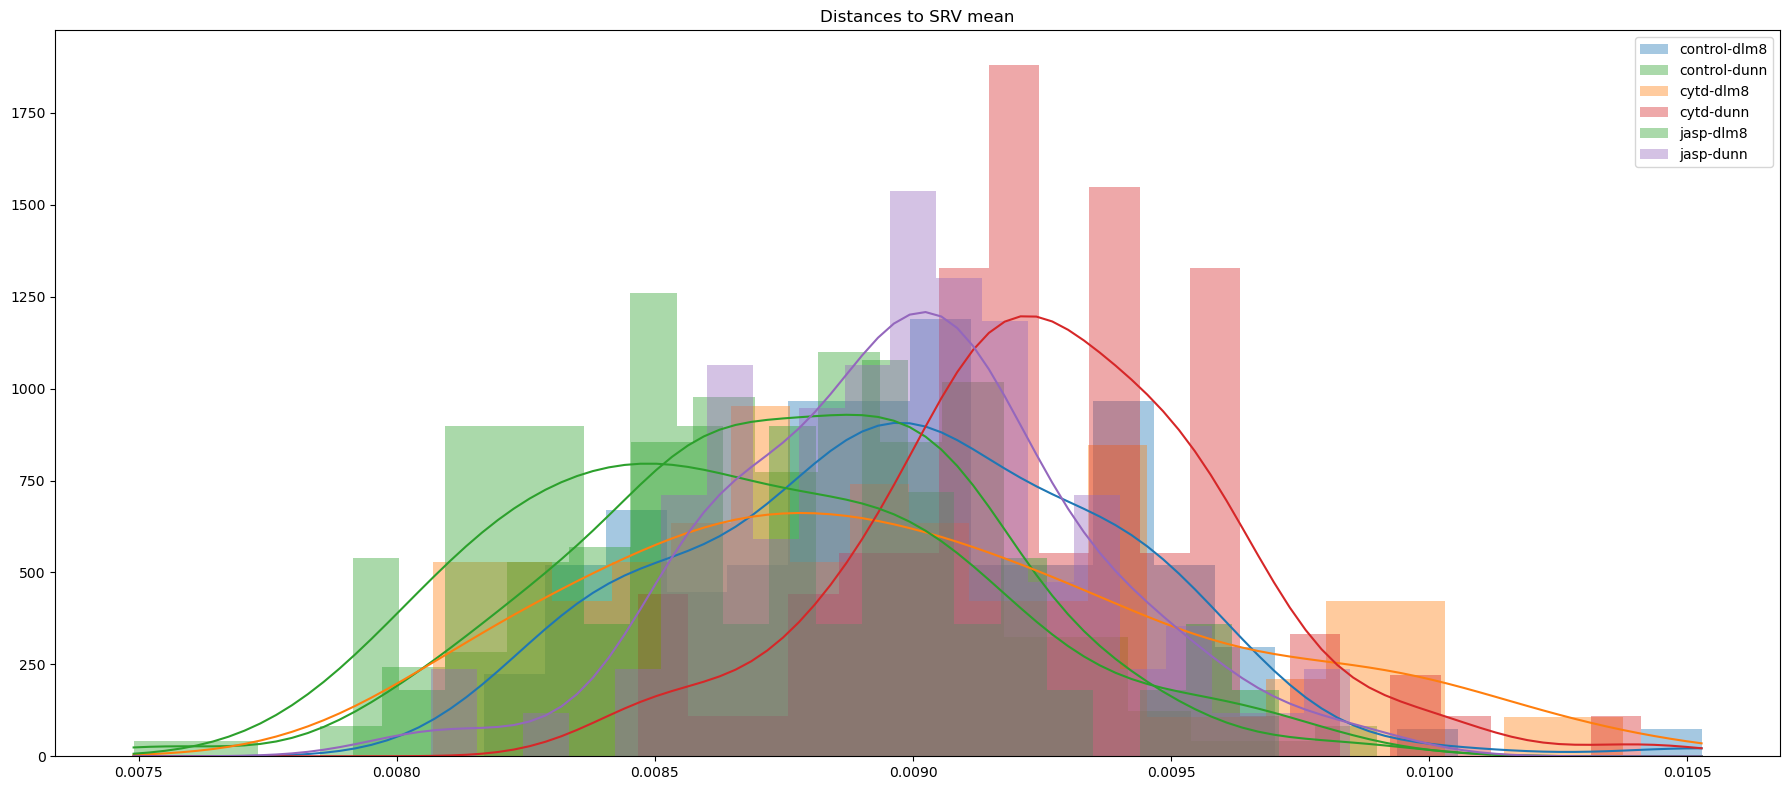

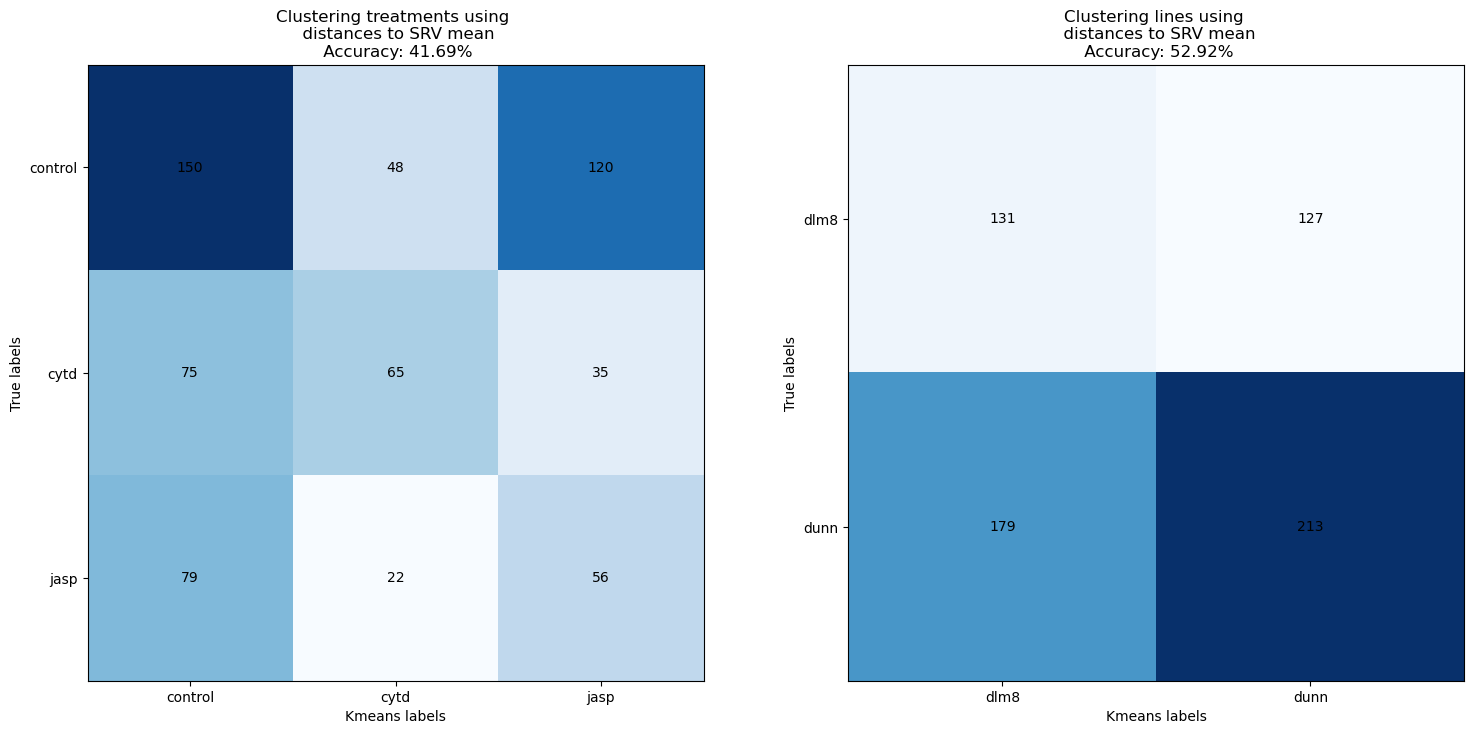

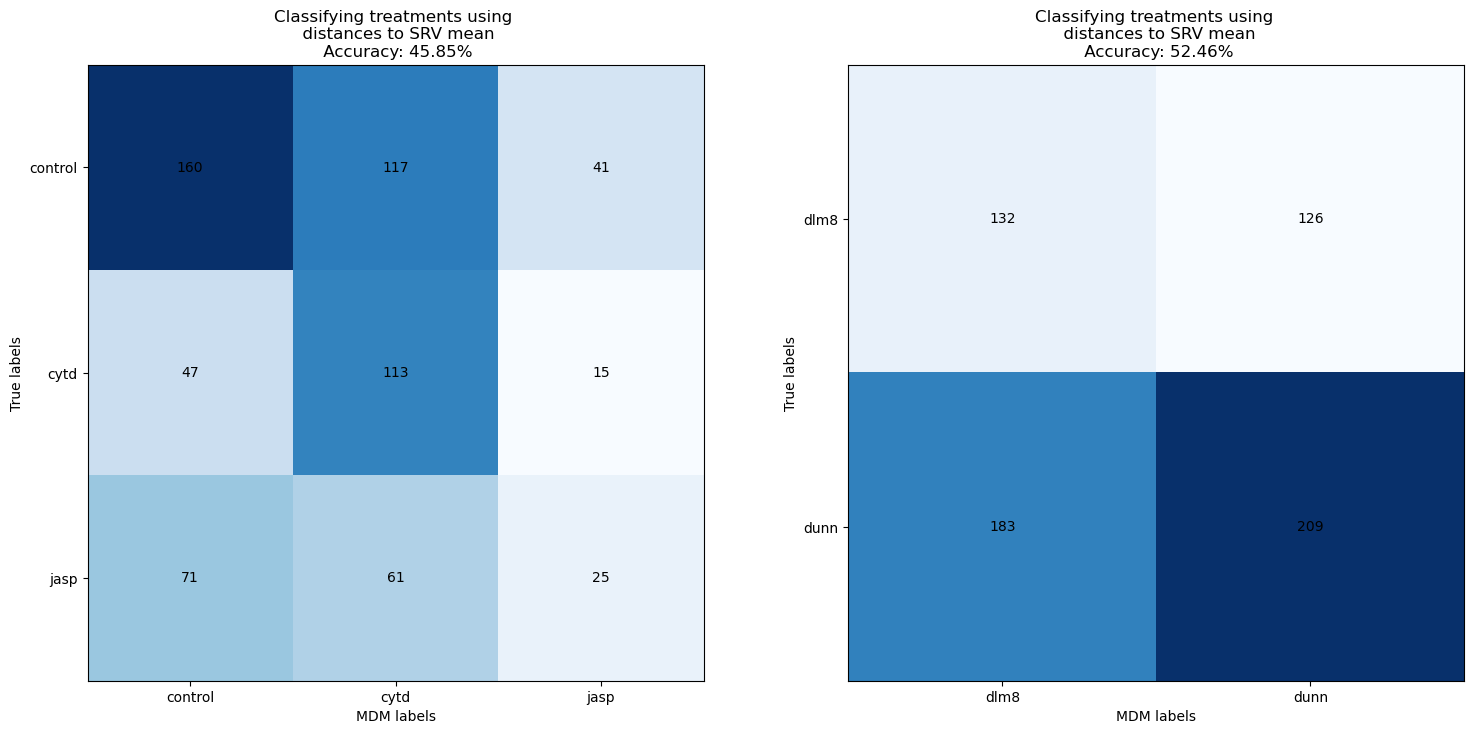

In [7]:
p = 0.2
sigma = 10.0

ds_interp = apply_func_to_ds(
    input_ds = ds,
    treatments = treatments_labels,
    lines = lines_labels,
    func = lambda x : preprocess(interpolate(x, k_sampling_points))
)

ds_noisy = apply_func_to_ds(
    input_ds = ds_interp,
    treatments = treatments_labels,
    lines = lines_labels,
    func = lambda x: curve_shot_noise(x, p, sigma)
)

ds_translate = apply_func_to_ds(
    input_ds = ds_noisy,
    treatments = treatments_labels,
    lines = lines_labels,
    func = lambda x : preshape.projection(x)
)

ds_preshape = apply_func_to_ds(
    input_ds = ds_translate,
    treatments = treatments_labels,
    lines = lines_labels,
    func = lambda x : x / curve_length(x)
)

mean = FrechetMean(
            metric = srv_metric, 
            method = "default").fit(unpack_dictionary(ds_preshape)).estimate_

dists = {}
for treatment in treatments_labels :
    dists[treatment] = {}
    for line in lines_labels :
        dists[treatment][line] = [srv_metric.dist(mean, curve) / k_sampling_points for curve in ds_preshape[treatment][line]]

dists_summary = pd.DataFrame(
    data = {
        'treatments': treatments,
        'lines': lines,
        'data': unpack_dictionary(dists)
    }
)

full_hist_dists_to_means_split(dists, treatments_labels, lines_labels)
full_hist_dists_to_means_gather(dists, treatments_labels, lines_labels)
confusion_kmean_double(treatments, lines, 'treatments', 'lines', treatments_dict, lines_dict, dists_summary)
confusion_mdm_double(treatments, lines, 'treatments', 'lines', treatments_dict, lines_dict, dists_summary)

### Accuracy of Clustering with Dfferent Amounts of Noise
We compute the accuracy of Riemannian MDM for different choices of the Gaussian noise width (given that the probability for each point being noisy = 1.0)

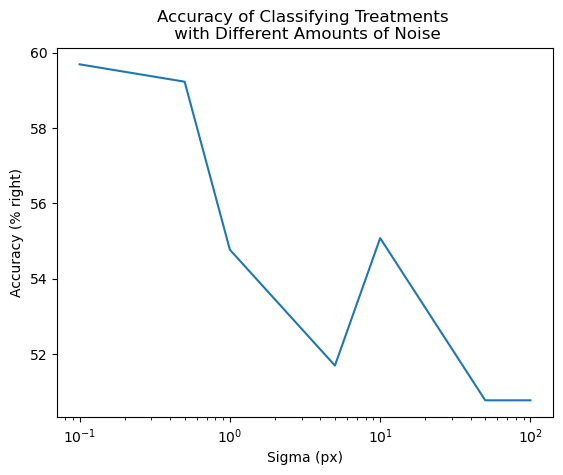

In [8]:
sigma = np.array([0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0])
accuracies = np.empty((sigma.shape[0], 2))

for i, value in enumerate(sigma) :

    ds_noisy = apply_func_to_ds(
        input_ds = ds_interp,
        treatments = treatments_labels,
        lines = lines_labels,
        func = lambda x: curve_shot_noise(x, 1.0, value)
    )

    ds_translate = apply_func_to_ds(
        input_ds = ds_noisy,
        treatments = treatments_labels,
        lines = lines_labels,
        func = lambda x : preshape.projection(x)
    )

    ds_preshape = apply_func_to_ds(
        input_ds = ds_translate,
        treatments = treatments_labels,
        lines = lines_labels,
        func = lambda x : x / curve_length(x)
    )

    mean = FrechetMean(
                metric = srv_metric, 
                method = "default").fit(unpack_dictionary(ds_preshape)).estimate_

    dists = {}
    for treatment in treatments_labels :
        dists[treatment] = {}
        for line in lines_labels :
            dists[treatment][line] = [srv_metric.dist(mean, curve) / k_sampling_points for curve in ds_preshape[treatment][line]]

    dists_summary = pd.DataFrame(
        data = {
            'treatments': treatments,
            'lines': lines,
            'data': unpack_dictionary(dists),
        }
    )

    accuracies[i, :] = mdm_accuracy(treatments, lines, 'treatments', 'lines', treatments_dict, lines_dict, dists_summary)

plt.semilogx(sigma, accuracies[:, 1])
plt.title('Accuracy of Classifying Treatments \n with Different Amounts of Noise')
plt.xlabel('Sigma (px)')
plt.ylabel('Accuracy (% right)')
plt.show()
    

### Accuracy of Clustering with Different Probability of Noise
We compute the accuracy of Riemannian MDM for different choices of the probability for each point being noisy (given that the Gaussian noise width = 1.0)

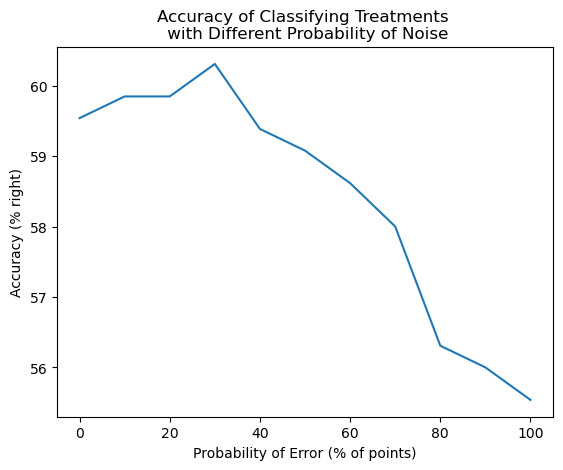

In [9]:
prob = np.linspace(0, 1, 11)
accuracies = np.empty((prob.shape[0], 2))

for i, value in enumerate(prob) :

    ds_noisy = apply_func_to_ds(
        input_ds = ds_interp,
        treatments = treatments_labels,
        lines = lines_labels,
        func = lambda x: curve_shot_noise(x,value, 1.0)
    )

    ds_translate = apply_func_to_ds(
        input_ds = ds_noisy,
        treatments = treatments_labels,
        lines = lines_labels,
        func = lambda x : preshape.projection(x)
    )

    ds_preshape = apply_func_to_ds(
        input_ds = ds_translate,
        treatments = treatments_labels,
        lines = lines_labels,
        func = lambda x : x / curve_length(x)
    )

    mean = FrechetMean(
                metric = srv_metric, 
                method = "default").fit(unpack_dictionary(ds_preshape)).estimate_

    dists = {}
    for treatment in treatments_labels :
        dists[treatment] = {}
        for line in lines_labels :
            dists[treatment][line] = [srv_metric.dist(mean, curve) / k_sampling_points for curve in ds_preshape[treatment][line]]

    dists_summary = pd.DataFrame(
        data = {
            'treatments': treatments,
            'lines': lines,
            'data': unpack_dictionary(dists),
        }
    )

    accuracies[i, :] = mdm_accuracy(treatments, lines, 'treatments', 'lines', treatments_dict, lines_dict, dists_summary)

plt.plot(100*prob, accuracies[:, 1])
plt.title('Accuracy of Classifying Treatments \n with Different Probability of Noise')
plt.xlabel('Probability of Error (% of points)')
plt.ylabel('Accuracy (% right)')
plt.show()

### Accuracy of Riemannian MDM for many sigma and probabilities
We compute the accuracy of Riemannian MDM for many different combinations of the Gaussian noise width and probability for each point being noisy to demonstrate that both have a noticeable consequence for the clustering algorithms ability to distinguish between each curve. You can see that as both probability and noise increase, the accuracy of cliassification goes down.

In [10]:
accuracies = np.empty((sigma.shape[0], prob.shape[0], 2))

for i, s in enumerate(sigma) :

    for j, p in enumerate(prob) :

        ds_noisy = apply_func_to_ds(
            input_ds = ds_interp,
            treatments = treatments_labels,
            lines = lines_labels,
            func = lambda x: curve_shot_noise(x, p, s)
        )

        ds_translate = apply_func_to_ds(
            input_ds = ds_noisy,
            treatments = treatments_labels,
            lines = lines_labels,
            func = lambda x : preshape.projection(x)
        )

        ds_preshape = apply_func_to_ds(
            input_ds = ds_translate,
            treatments = treatments_labels,
            lines = lines_labels,
            func = lambda x : x / curve_length(x)
        )

        mean = FrechetMean(
                    metric = srv_metric, 
                    method = "default").fit(unpack_dictionary(ds_preshape)).estimate_

        dists = {}
        for treatment in treatments_labels :
            dists[treatment] = {}
            for line in lines_labels :
                dists[treatment][line] = [srv_metric.dist(mean, curve) / k_sampling_points for curve in ds_preshape[treatment][line]]

        dists_summary = pd.DataFrame(
            data = {
                'treatments': treatments,
                'lines': lines,
                'data': unpack_dictionary(dists),
            }
        )

        accuracies[i, j, :] = mdm_accuracy(treatments, lines, 'treatments', 'lines', treatments_dict, lines_dict, dists_summary)

### Accuracy for Treatments
The labels on the plots describe the format with the color representing the accuracy of Riemannian MDM clustering for different treatments. The clustering on the original dataset of treatments was relatively robust given that the expected asymptotic value for the accuracy is 33.0% if you increase probability and noise further. The accuracy of clustering on the noisy datasets begins to approach this asymptotic value for increasing probability and noise, and thus has a significant consequence for clustering.

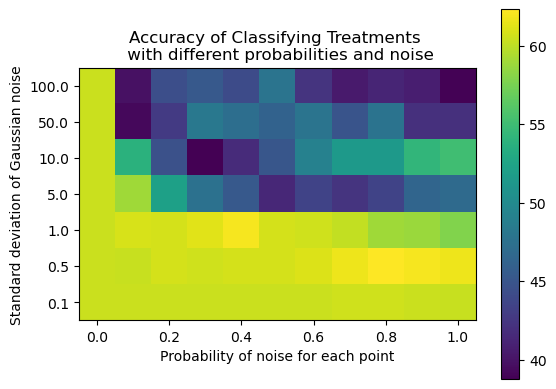

In [11]:
@plt.FuncFormatter
def fake_prob(x, pos) :
    'The two args are the value and tick position'
    return x / 10

@plt.FuncFormatter
def fake_log(y, pos) :
    'The two args are the value and tick position'
    return sigma[- (int(y) % sigma.shape[0] + 1)]

fig, (ax1) = plt.subplots()
plotted = accuracies[::-1, :, 0]
pos = ax1.imshow(plotted)
ax1.yaxis.set_major_formatter(fake_log)
ax1.xaxis.set_major_formatter(fake_prob)

# plt.imshow(accuracies[:, :, 0], aspect = 'auto')
fig.colorbar(pos, ax = ax1)
plt.xlabel('Probability of noise for each point')
plt.ylabel('Standard deviation of Gaussian noise')
plt.title('Accuracy of Classifying Treatments \n with different probabilities and noise')
plt.show()

### Accuracy for Cell Lines
The labels on the plots describe the format with the color representing the accuracy of Riemannian MDM clustering for different cell lines. The clustering on the original dataset of cell lines was not that robust given that the expected asymptotic value for the accuracy is 50.0% if you increase probability and noise further. The accuracy of clustering on the noisy datasets reaches this asymptotic value for increasing probability and noise, and thus still has a significant consequence for clustering.

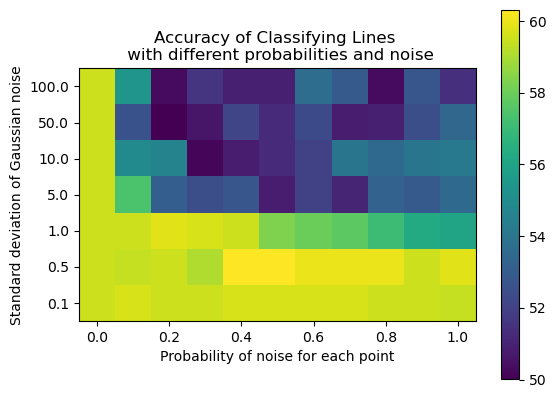

In [12]:
@plt.FuncFormatter
def fake_prob(x, pos) :
    'The two args are the value and tick position'
    return x / 10

@plt.FuncFormatter
def fake_log(y, pos) :
    'The two args are the value and tick position'
    return sigma[- (int(y) % sigma.shape[0] + 1)]

fig, (ax1) = plt.subplots()
plotted = accuracies[::-1, :, 1]
pos = ax1.imshow(plotted)
ax1.yaxis.set_major_formatter(fake_log)
ax1.xaxis.set_major_formatter(fake_prob)

# plt.imshow(accuracies[:, :, 0], aspect = 'auto')
fig.colorbar(pos, ax = ax1)
plt.xlabel('Probability of noise for each point')
plt.ylabel('Standard deviation of Gaussian noise')
plt.title('Accuracy of Classifying Lines \n with different probabilities and noise')
plt.show()